# Automatic Generation of Body Masks
In cases when a body mask contour is not provided. For example:
1. Patient N046 doesn't have a body contour in the RTSTRUCT file
2. The non-registered ldCT and HX4-PET images of all patients

In [6]:
from scipy import ndimage
import cv2
import numpy as np
import SimpleITK as sitk

from viz_utils import NdimageVisualizer

In [2]:
visualizer = NdimageVisualizer()

## Utils
Functions `smooth_contour_points()` and `get_body_mask()` taken from midaGAN

In [3]:
def get_body_mask(image: np.ndarray, hu_threshold: int) -> np.ndarray:
    """
    Function that gets a mask around the patient body and returns a 3D bound

    Parameters
    -------------
    image: Numpy array to get the mask and bound from
    hu_threshold: Set threshold to binarize image


    Returns
    -------------
    body_mask: Numpy array with same shape as input image as a body mask
    bound: Bounds around the largest component in 3D. This is in
    the ((z_min, z_max), (y_min, y_max), (x_min, x_max)) format
    """

    binarized_image = np.uint8(image >= hu_threshold)

    body_mask = np.zeros(image.shape)

    # Returns a label map with a unique integer label for each
    # connected gehttp://localhost:8888/notebooks/Auto_Body_Mask_Generation.ipynb#ometrical object in the given binary array.
    # Integer labels of components start from 1. Background is 0.
    connected_components, _ = ndimage.label(binarized_image)

    # Get counts for each component in the connected component analysis
    label_counts = [
        np.sum(connected_components == label) for label in range(1,
                                                                 connected_components.max() + 1)
    ]
    max_label = np.argmax(label_counts) + 1

    # Image with largest component binary mask
    binarized_image = connected_components == max_label

    for z in range(binarized_image.shape[0]):

        binary_slice = np.uint8(binarized_image[z])

        # Find contours for each binary slice
        try:
            contours, _ = cv2.findContours(binary_slice, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            # Get the largest contour based on its area
            largest_contour = max(contours, key=cv2.contourArea)

        except:
            logger.debug(
                "OpenCV could not find contours: Most likely this is a completely black image")
            continue

        # Smooth contour so that surface irregularities are removed better
        smoothed_contour = smooth_contour_points(largest_contour)

        # Project the points onto the body_mask image, everything
        # inside the points is set to 1.
        cv2.drawContours(body_mask[z], [smoothed_contour], -1, 1, -1)

    return body_mask


def smooth_contour_points(contour: np.ndarray, radius: int = 3, sigma: int = 10) -> np.ndarray:
    """
    Function that smooths contour points using the approach from 
    https://stackoverflow.com/a/37536310
    
    Simple explanation: Convolve 1D gaussian filter over the points to smoothen the curve
    """
    neighbourhood = 2 * radius + 1

    # Contour length is the total number of points + extra points
    # to ensure circularity.
    contour_length = len(contour) + 2 * radius
    # Last group of points.
    offset = (len(contour) - radius)

    x_filtered, y_filtered = [], []

    for idx in range(contour_length):
        x_filtered.append(contour[(offset + idx) \
                                          % len(contour)][0][0])

        y_filtered.append(contour[(offset + idx) \
                                          % len(contour)][0][1])

    # Gaussian blur from opencv is basically applying gaussian convolution
    # filter over these points.
    x_smooth = cv2.GaussianBlur(np.array(x_filtered), (radius, 1), sigma)
    y_smooth = cv2.GaussianBlur(np.array(y_filtered), (radius, 1), sigma)

    # Add smoothened point for
    smooth_contours = []
    for idx, (x, y) in enumerate(zip(x_smooth, y_smooth)):
        if idx < len(contour) + radius:
            smooth_contours.append(np.array([x, y]))

    return np.array(smooth_contours)


## Run

In [9]:
DATA_DIR = "/home/chinmay/Datasets/HX4-PET-Translation/Processed"
PATIENT = "N046"
HU_THRESHOLD = -300

In [7]:
fdg_pet = sitk.ReadImage(f"{DATA_DIR}/val/{PATIENT}/fdg_pet.nrrd")
pct = sitk.ReadImage(f"{DATA_DIR}/val/{PATIENT}/pct.nrrd")
hx4_pet_reg = sitk.ReadImage(f"{DATA_DIR}/val/{PATIENT}/hx4_pet_reg.nrrd")
ldct_reg = sitk.ReadImage(f"{DATA_DIR}/val/{PATIENT}/ldct_reg.nrrd")

fdg_pet = sitk.GetArrayFromImage(fdg_pet)
pct = sitk.GetArrayFromImage(pct)
hx4_pet_reg = sitk.GetArrayFromImage(hx4_pet_reg)
ldct_reg = sitk.GetArrayFromImage(ldct_reg)

In [8]:
body_mask = get_body_mask(pct, HU_THRESHOLD)

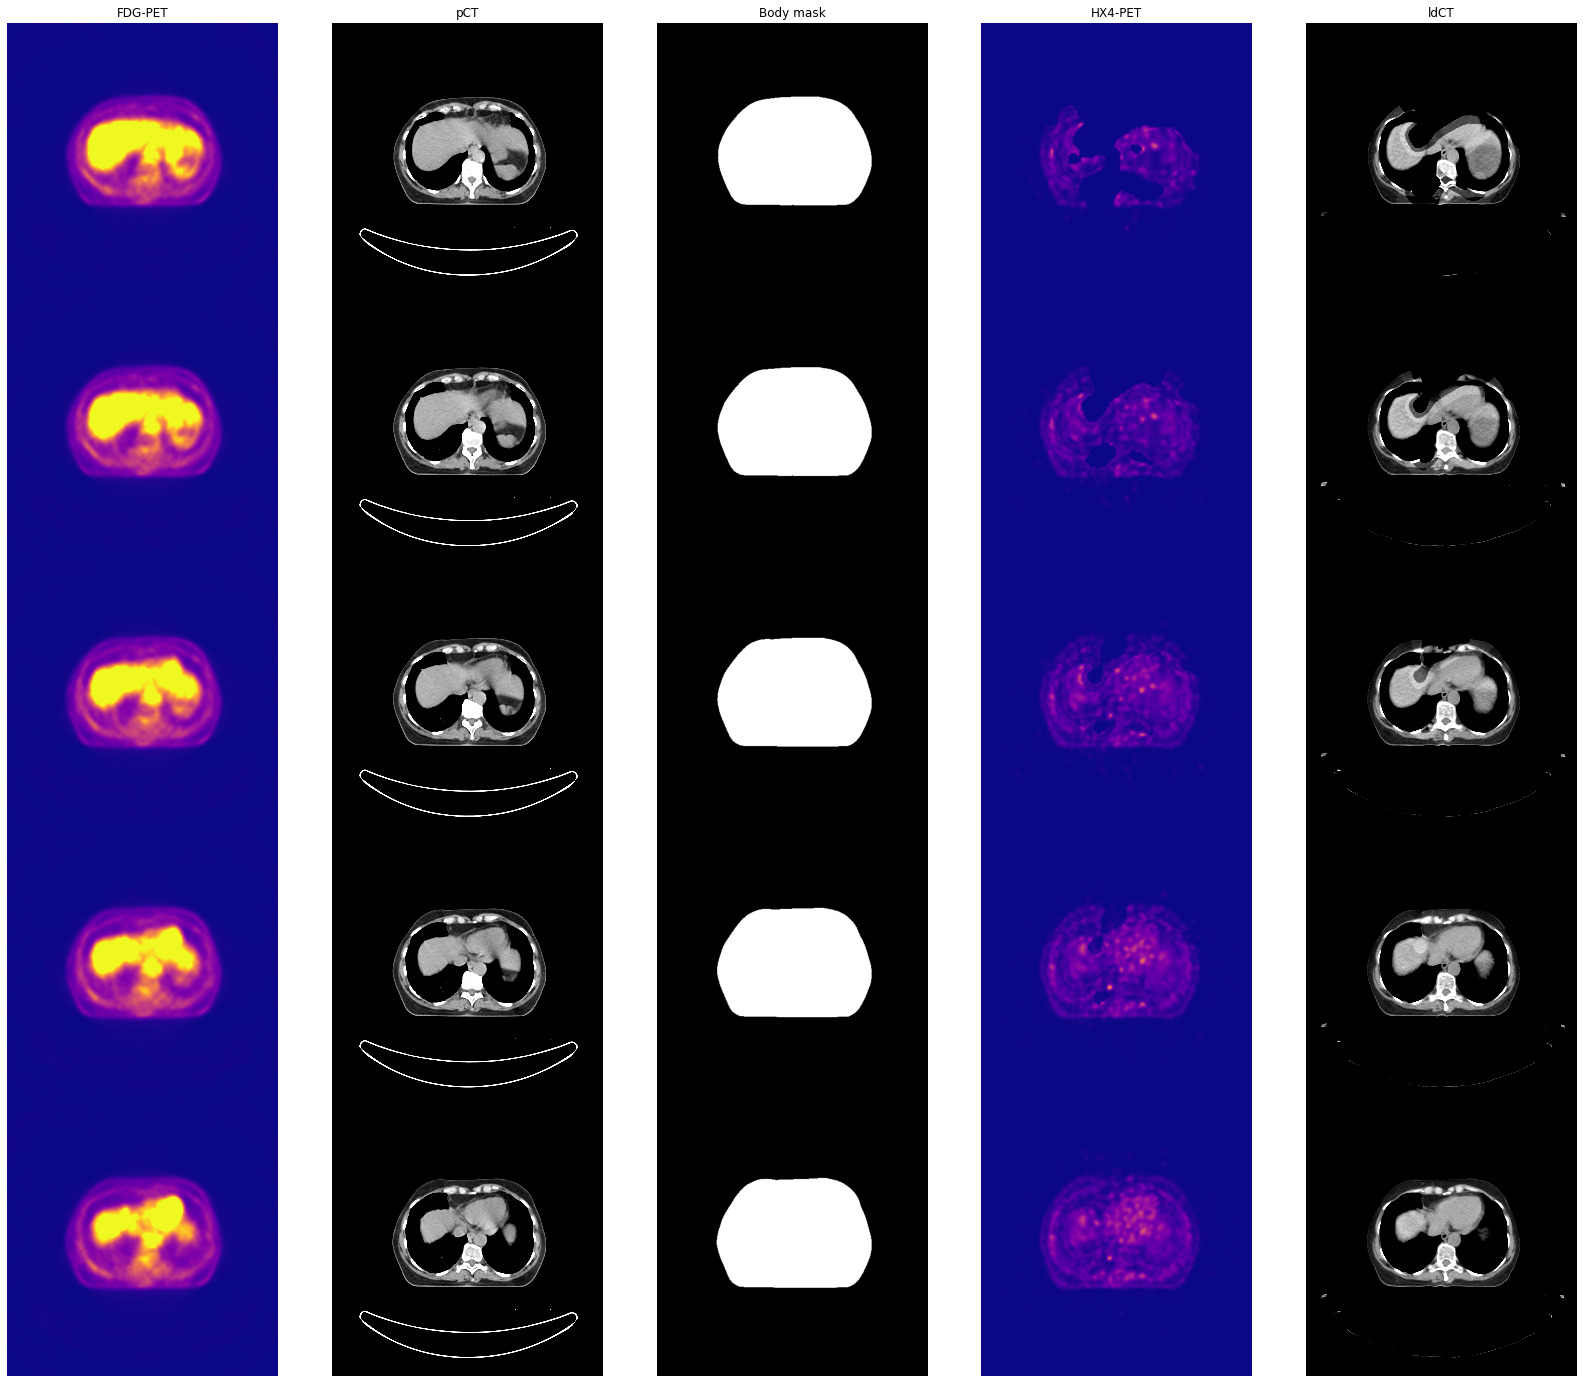

In [12]:
# Visualize
fdg_pet = fdg_pet.transpose(2,1,0)
pct = pct.transpose(2,1,0)
body_mask = body_mask.transpose(2,1,0) 
hx4_pet_reg = hx4_pet_reg.transpose(2,1,0)
ldct_reg = ldct_reg.transpose(2,1,0)

visualizer.set_spacing((1,1,3))
visualizer.multi_image_strips([fdg_pet, pct, body_mask, hx4_pet_reg, ldct_reg], 
                              image_types=['PET', 'CT', 'labelmap', 'PET', 'CT'], 
                              idx_range=[0, 5], 
                              view='axial',
                              subtitles=['FDG-PET', 'pCT', 'Body mask', 'HX4-PET', 'ldCT'])

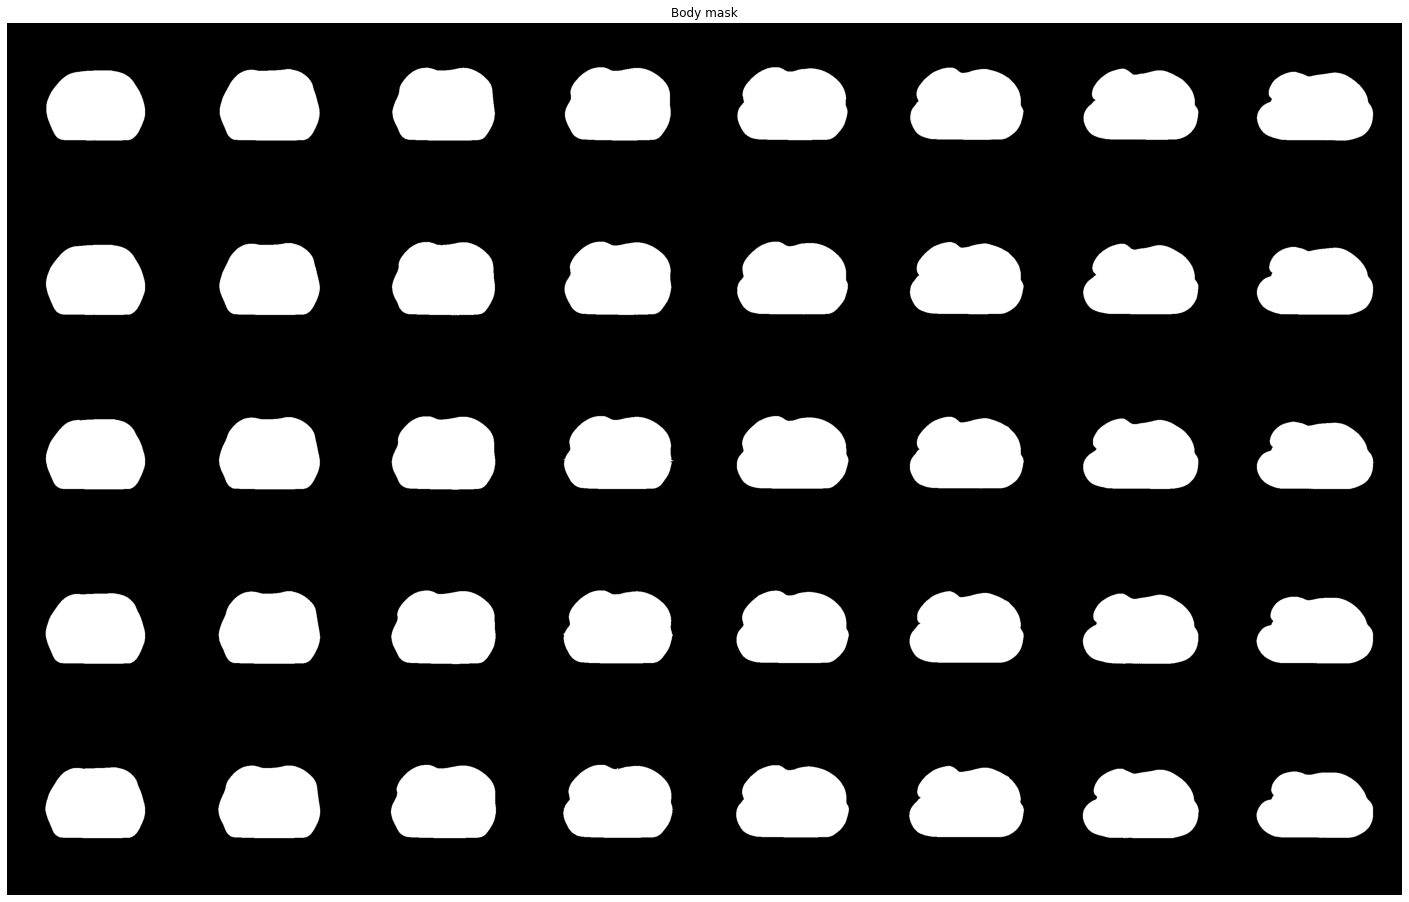

In [13]:
visualizer.grid(body_mask, idx_range=[0,40], view='axial', image_type='labelmap', title="Body mask")